In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling
import statsmodels.api as sm
import pandas as pd
import os
import re
from unidecode import unidecode
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from multiprocessing import Pool, cpu_count
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
data = pd.read_csv('../datasets/full-dv-data.csv')

In [5]:
def remove_columns(df):
    columns_to_remove = ['Campus', 'Sede', 'Nome', 'Código', 'Data de ingresso', 'Data de nascimento', 'Matriz curricular', 
                         'Município', 'Município SiSU', 'Município (SISU)', 'UF SISU', 'UF (SISU)', 'E-mail', 'Funcionamento', 'Sede']
    return df.drop(columns=[col for col in columns_to_remove if col in df.columns])

In [6]:
 df = remove_columns(data)

In [13]:
def make_valid_name(name):
    if name == 'Situação atual':
        return 'situacao'
    elif name == 'Situação':
        return 'situacao'
    else:
        name = unidecode(name)
        name = re.sub(r'\W+', '_', name)
        name = '_'.join(filter(None, name.lower().split('_')))
        return name

In [8]:
def rename_columns(df):
    bad_names = df.columns.tolist()
    good_names = [make_valid_name(name) for name in bad_names]
    bad_to_good_converter = dict(zip(bad_names, good_names))
    df.rename(columns=bad_to_good_converter, inplace=True)
    return df

In [16]:
df = rename_columns(df)

In [17]:
data = df[(df['situacao'] == 'Desistente') | (df['situacao'] == 'Formado') | 
          (df['situacao'] == 'Regular') | (df['situacao'] == 'Trancado')]
data.loc[data['situacao'] == 'Formado', 'situacao'] = 'Regular'
data.loc[data['situacao'] == 'Trancado', 'situacao'] = 'Desistente'
data.loc[:, 'target'] = data['situacao'].replace({'Regular': 0, 'Desistente': 1})

KeyError: 'situacao'

In [10]:
def pre_process(data,dataset_name):

    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

    #class_plot(data,dataset_name)
   
    # removendo colunas com mais de 50% de valores ausentes
    data = data.dropna(axis=1, thresh=len(data) * 0.5)
    
    columns = data.columns.tolist()

    for column in columns:
        if data[column].dtype == 'object':
            data.loc[:, column] = pd.Categorical(data[column])
            data.loc[:, column] = LabelEncoder().fit_transform(data[column])
        
        data.loc[:, column] = data[column].astype(str).str.replace(',', '.', regex=True)
        data.loc[:, column] = pd.to_numeric(data[column], errors='coerce')


    return data

In [11]:
def const_remove(data,threshold):
    constant_filter = VarianceThreshold(threshold)
    constant_filter.fit(data)
    data = data.iloc[:, constant_filter.get_support()]
    
    return data

def imputation(data):
    imputer = SimpleImputer(strategy='mean')
    df_imputed = imputer.fit_transform(data)
    data = pd.DataFrame(data=df_imputed, columns=data.columns)

    return data

In [12]:
def correlation(data,threshold):
    corr = data.corr()
    mask = (corr > threshold) | (corr < (-threshold))
    columns_to_drop = []
    for col in mask.columns:
        correlated_cols = mask.index[mask[col]].tolist()
        if len(correlated_cols) > 1:
            columns_to_drop.extend(correlated_cols[1:])
    
    data = data.drop(columns=columns_to_drop)
    return data


In [13]:
def load_models():
    model_mapping = {
        'dt': DecisionTreeClassifier(random_state=0, ccp_alpha=0.02),
        'rf': RandomForestClassifier(n_estimators=100, random_state=0),
        'neigh': KNeighborsClassifier(n_neighbors=3),
        'nb': GaussianNB()
    }
      
    return model_mapping

In [14]:
def train_test(x, y, dataset_name, algorithm, corr_threshold, const_threshold, seed):
    
    n_samples = len(y)
    n_splits = min(10, n_samples)

    model_mapping = load_models()
    results = {'Model': [], 'Accuracy': [], 'Balanced Accuracy': [],  'f1-score': [],  'recall': [],  'precision': [], 'CM - True Positive': [], 'CM - False Negative': [], 'CM - False Positive': [], 'CM - True Negative': []}

    classifier = model_mapping[algorithm]
    y = pd.to_numeric(y, errors='coerce')


    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    y_pred = cross_val_predict(classifier, x, y, cv=cv)
    classifier.fit(x, y)

    predict_df = pd.DataFrame({'True_Label': y, 'Predicted_Label': y_pred})

    if not os.path.exists('predictions'):
        os.makedirs('predictions') 
    predict_df.to_csv(f'predictions/predict-{dataset_name}-{algorithm}-{corr_threshold}-{const_threshold}-{seed}.csv', index=False)

    acc = accuracy_score(y, y_pred)
    bac = balanced_accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)  

    print(f1)
    
    cm = confusion_matrix(y, y_pred)
    
    results['Model'].append(algorithm)
    results['Accuracy'].append(acc)
    results['Balanced Accuracy'].append(bac)
    results['f1-score'].append(f1)
    results['recall'].append(recall)
    results['precision'].append(precision)

    # Verifique se a matriz de confusão tem o tamanho esperado (2x2)
    if cm.shape == (2, 2):
        results['CM - True Positive'].append(cm[0][0])
        results['CM - False Negative'].append(cm[0][1])
        results['CM - False Positive'].append(cm[1][0])
        results['CM - True Negative'].append(cm[1][1])
    else:
        results['CM - True Positive'].append(None)
        results['CM - False Negative'].append(None)
        results['CM - False Positive'].append(None)
        results['CM - True Negative'].append(None)

    features = x.columns.tolist()

    return classifier, features, cm

Quantidade de features antes da remoção:
44
Quantidade de features após remoção de constantes:
33
Quantidade de features após remoção por correlação:
31
0.9022556390977444
Features utilizadas no modelo:
['Grau', 'Turno', 'Curso', 'genero', 'ano', 'semestre', 'cor_ou_raca', 'codigo_do_curso', 'disciplinas_aprovadas', 'disciplinas_consignadas', 'disciplinas_matriculadas', 'disciplinas_reprovadas_por_frequencia', 'disciplinas_reprovadas_por_nota', 'forma_de_ingresso', 'idade', 'nota_enem_humanas', 'nota_enem_liguagem', 'nota_enem_matematica', 'nota_enem_natureza', 'nota_enem_redacao', 'nota_final_sisu_vestibular', 'numero_de_entradas_em_outros_cursos', 'pais_de_nascimento', 'periodo', 'retencao_parcial', 'retencao_total', 'semestre_de_ingresso_no_curso', 'tipo_de_cota', 'total_de_periodos_do_curso', 'total_de_semestres_cursados', 'uf']

Matriz de Confusão:
[[36507   757]
 [  517  5880]]


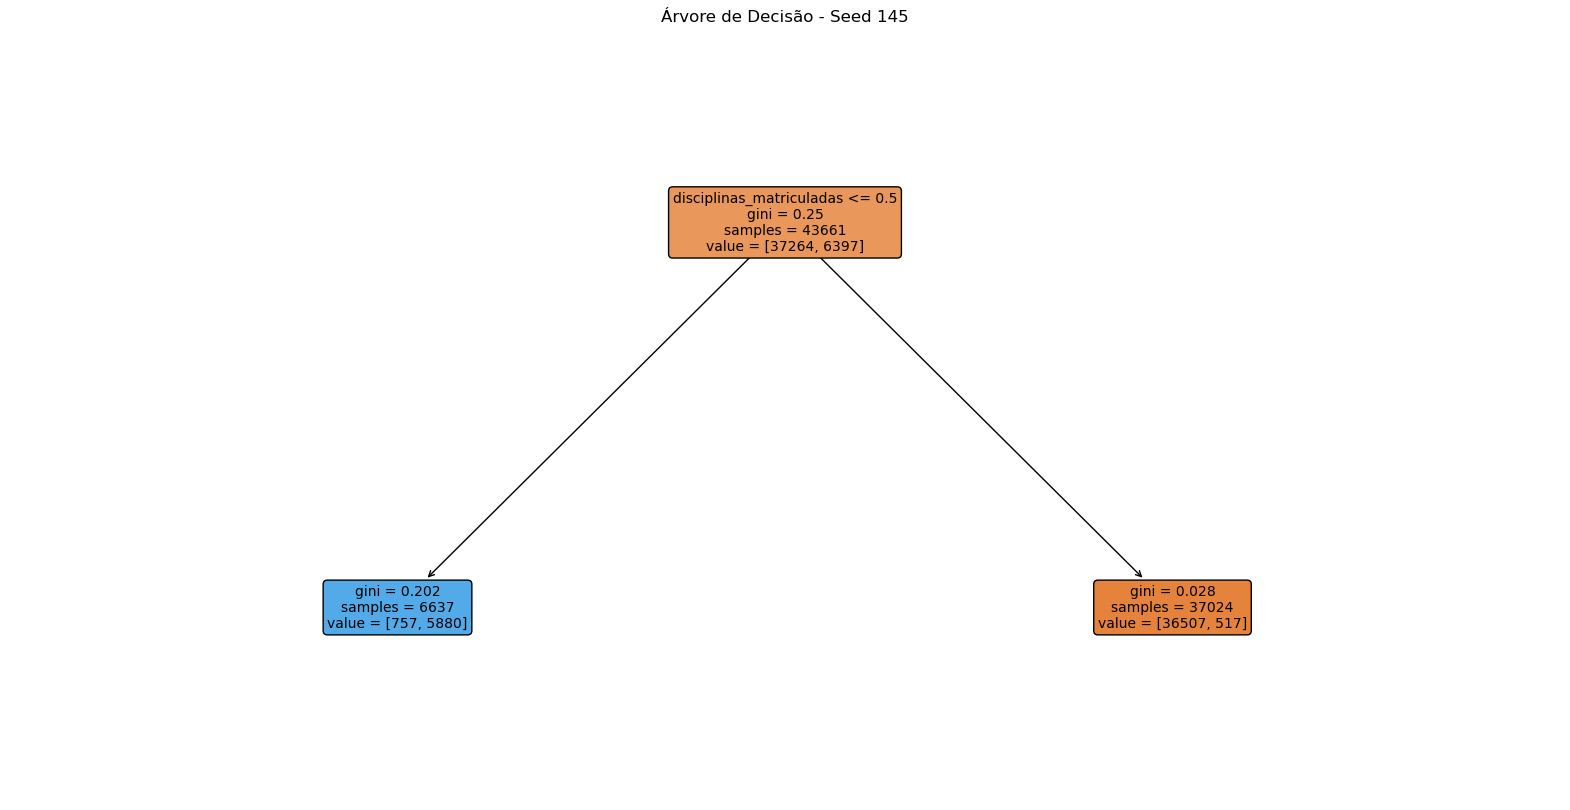

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Função de execução simplificada
def execute_single_run(data, algorithm, corr_threshold, const_threshold, seed):
    y = data['target']
    data = pre_process(data, "teste")

    features = data.columns.tolist()
    features.remove('target')
    x = data[features]

    print("Quantidade de features antes da remoção:")
    print(len(features))

    data = const_remove(x, const_threshold)
    print("Quantidade de features após remoção de constantes:")
    print(len(data.columns))  # Verificando quantas features restaram após a remoção de constantes

    data = imputation(data)
    data = const_remove(data, const_threshold)  # Remover novamente após imputação
    data = correlation(data, corr_threshold)
    print("Quantidade de features após remoção por correlação:")
    print(len(data.columns))  # Verificando quantas features restaram após remoção por correlação

    classifier, final_features, cm = train_test(data, y, "teste", algorithm, corr_threshold, const_threshold, seed)

    feature_mapping = {
        'grau': 'Grau',
        'curso': 'Curso',
        'turno': 'Turno',
        # (restante do mapeamento)
    }

    # Ajustando os nomes das features
    mapped_features = [feature_mapping.get(feat, feat) for feat in final_features]

    importance = classifier.feature_importances_ if hasattr(classifier, "feature_importances_") else []
    importance_df = pd.DataFrame({'Feature': mapped_features, 'Importância': importance})
    importance_df = importance_df.sort_values(by='Importância', ascending=False)

    return classifier, mapped_features, cm

# Definindo os parâmetros
seed = 145
corr_threshold = 0.85  # Tente diminuir esse valor se muitas features estiverem sendo removidas
const_threshold = 0.05  # Ajuste esse valor para garantir que mais features sejam preservadas
algorithm = 'dt'

# Executando o modelo
classifier, feature_names, cm = execute_single_run(data, algorithm, corr_threshold, const_threshold, seed)

# Exibindo as importâncias das features
print("Features utilizadas no modelo:")
print(feature_names)

# Exibindo a matriz de confusão
print("\nMatriz de Confusão:")
print(cm)

# Plotando a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(
    classifier,
    feature_names=feature_names,  # Nomes mapeados das features
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Árvore de Decisão - Seed {seed}")
plt.show()
